# Графовая модель

### Импорт модулей

In [ ]:
!apt-get install graphviz graphviz-dev

In [23]:
!pip install torcheval pygraphviz --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [24]:
import torch
from torch import nn
from torch.fx import symbolic_trace
import torch.utils.data
import torchvision
from torchvision import transforms
from torcheval.metrics import BinaryAUROC
import torch.fx as fx
from torchvision.models import resnet50

import numpy as np
from scipy.stats import spearmanr, kendalltau

import abc
from typing import Any, Callable, Dict, List, Optional, Tuple, Set
from functools import reduce, partial
import re
import copy
import collections
from collections import defaultdict
from __future__ import annotations

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import networkx as nx

sns.set_style('darkgrid')

### Реализации модулей и функций

Утилиты.

In [ ]:
def get_dataloaders(classes: List[int], batch_size: int = 16, img_size: int = 33, need_val: bool = False, cifar100: bool = False, train_limit = None):
    classes_to_ids = {cls : i for i, cls in enumerate(classes)}
    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if cifar100:
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    else:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
        
    trainset = [(x, classes_to_ids[y]) for x, y in trainset if y in classes]
    if need_val:
        _trainset = trainset[:len(trainset)//2]
        valset  = trainset[len(trainset)//2:]
        trainset = _trainset
    if train_limit:
        trainset = trainset[:train_limit]
        
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    if need_val:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True)
    if cifar100:
        testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    else:
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    testset = [(x, classes_to_ids[y]) for x, y in testset if y in classes]
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False)
    if need_val:
        return trainloader, valloader, testloader
    return trainloader, testloader

def train_loop(model, traindata, testdata, epoch_num=1, lr=1e-3, device='cuda'):
    history = []
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    batch_seen = 0
    
    for epoch_num in range(epoch_num):
        losses = []
        tq = tqdm(traindata, leave=False)
        
        for x, y in tq:
            optim.zero_grad()
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            
            if not isinstance(out, torch.Tensor):
                out = out[0] #  when features are also returned in forward
            
            loss = criterion(out, y)
            loss.backward()
            optim.step()
            losses.append(loss.cpu().detach().numpy())
            
            batch_seen += 1
            metric_result = test_loop(model, testdata, device)
            tq.set_description(f'Epoch: {epoch_num}, Loss: {str(np.mean(losses))}, ROC-AUC: {metric_result}')
            history.append(metric_result)
                
    return history

def test_loop(model, testdata, device='cuda', return_loss=False):
    criterion = torch.nn.CrossEntropyLoss()
    metric = BinaryAUROC(device=device)
    model.to(device)
    model.eval()
    loss = 0.0

    for x, y in testdata:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        if not isinstance(out, torch.Tensor):
            out = out[0] #  when features are also returned in forward
        pred = out.argmax(-1)
        metric.update(pred, y)
        if return_loss:
            loss += criterion(out, y).detach().cpu().item()
    
    metric_result = metric.compute().item()
    
    model.train()
    if return_loss:
        return loss
    
    return metric_result

def get_model(device='cuda'):
    trainloader, testloader = get_dataloaders([8,9], batch_size=64)
    full_model = resnet50(pretrained=True)
    full_model.fc = torch.nn.Linear(full_model.fc.in_features, 2)
    train_loop(full_model, trainloader, testloader)
    full_model = full_model.to(device)

    return full_model

Утилиты для графовой модели.

In [ ]:
def trace_model(model: nn.Module, example_input: torch.Tensor) -> fx.GraphModule:
    model.eval()
    return fx.symbolic_trace(model)

def infer_input_channels(x: torch.Tensor) -> int:
    if x.ndim < 2:
        return 1
    return x.shape[1]

def aggregate_gamma(gamma: torch.Tensor, mode: str = "mean") -> float:
    if mode == "mean":
        return gamma.mean().item()
    elif mode == "max":
        return gamma.max().item()
    elif mode == "l1":
        return gamma.abs().sum().item()
    else:
        raise ValueError(f"Unknown aggregation mode: {mode}")

def visualize_graph(
    graph_model: GraphModel,
    gamma_mode: str = "mean",
    figsize=(12, 6)
):
    G = graph_model.to_networkx(gamma_mode)

    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")

    plt.figure(figsize=figsize)

    # Узлы
    node_labels = {
        n: f"{G.nodes[n].get('label', n)}\n({n})"
        for n in G.nodes
    }

    nx.draw_networkx_nodes(
        G, pos,
        node_color="lightblue",
        node_size=2000
    )

    nx.draw_networkx_labels(
        G, pos,
        labels=node_labels,
        font_size=9
    )

    # Рёбра
    edges = G.edges(data=True)
    widths = [20 * d["gamma"] for (_, _, d) in edges]
    for (edge, width) in zip(edges, widths):
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(edge[0], edge[1])],
            width=width,
            edge_color="black",
            arrows=True,
            arrowstyle="-|>",
            arrowsize=20,
            node_size=2000,
                )

    # Подписи рёбер
    edge_labels = {
        (u, v): f"gamma={d['gamma']:.3f}\nC={d['channels']}"
        for u, v, d in edges
    }

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=8
    )

    plt.axis("off")
    plt.show()

Реализация графовой модели.

In [ ]:
class GraphEdge(nn.Module):
    """
    Represents a single information flow channel.
    gamma = 0 → no information flow
    gamma > 0 → scaled flow
    """
    def __init__(self, src: str, dst: str, channels: int):
        super().__init__()
        self.src = src
        self.dst = dst
        self.gamma = nn.Parameter(
            torch.ones(channels) / channels
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, C, ...]
        shape = [1, -1] + [1] * (x.ndim - 2)
        return x * self.gamma.view(*shape)


class GraphNode(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self.module = module
        self.edges_in = nn.ModuleList()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.edges_in:
            x = sum(edge(x) for edge in self.edges_in)
        return self.module(x)


class GraphModel(nn.Module):
    def __init__(self, fx_model: fx.GraphModule, example_input: torch.Tensor):
        super().__init__()

        self.fx_model = fx_model
        self.nodes = nn.ModuleDict()
        self.edges = nn.ModuleList()

        self._build_graph(example_input)


    def _build_graph(self, example_input):
        env = {}
        x = example_input

        for node in self.fx_model.graph.nodes:
            if node.op == 'placeholder':
                env[node.name] = x

            elif node.op == 'call_module':
                module = dict(self.fx_model.named_modules())[node.target]

                gnode = GraphNode(module)
                self.nodes[node.name] = gnode

                input_tensor = env[node.args[0].name]
                channels = infer_input_channels(input_tensor)

                edge = GraphEdge(src=node.args[0].name, dst=node.name, channels=channels)
                gnode.edges_in.append(edge)
                self.edges.append(edge)

                env[node.name] = gnode(input_tensor)

            elif node.op == 'output':
                self.output_node = node.args[0].name
    
    def forward(self, x):
        env = {}

        for node in self.fx_model.graph.nodes:
            if node.op == 'placeholder':
                env[node.name] = x

            elif node.op == 'call_module':
                gnode = self.nodes[node.name]
                inp = env[node.args[0].name]
                env[node.name] = gnode(inp)

            elif node.op == 'output':
                return env[node.args[0].name]
    

    def to_networkx(self, gamma_mode="mean"):
        G = nx.DiGraph()

        for name, gnode in self.nodes.items():
            G.add_node(
                name,
                label=gnode.module.__class__.__name__
            )

        for edge in self.edges:
            gamma_val = aggregate_gamma(edge.gamma, gamma_mode)
            G.add_edge(
                edge.src,
                edge.dst,
                gamma=gamma_val,
                channels=edge.gamma.numel()
            )

        return G

### Постоение графовой модели на примерах

#### FCN

Модель.

In [73]:
model = nn.Sequential(
    nn.Linear(10, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

Построение графовой модели.

In [74]:
example = torch.randn(1, 10)

fx_model = trace_model(model, example)
graph_model = GraphModel(fx_model, example)

out = graph_model(example)

Визуализация графа.

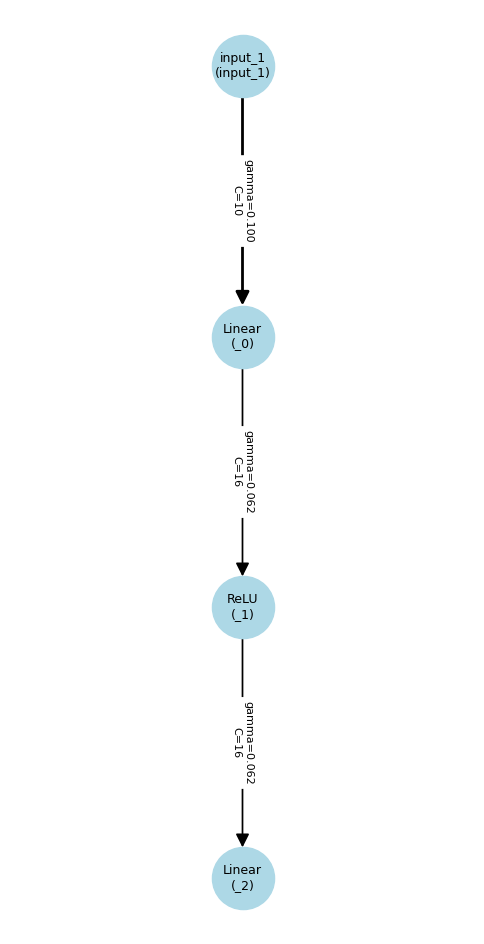

In [75]:
visualize_graph(graph_model, gamma_mode="mean", figsize=(6, 12))

#### Простая CNN

Модель.

In [76]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, 3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return self.conv2(x)


Построение графовой модели.

In [77]:
model = SimpleCNN()
example = torch.randn(1, 3, 32, 32)

fx_model = trace_model(model, example)
graph_model = GraphModel(fx_model, example)

out = graph_model(example)


Визуализация графа.

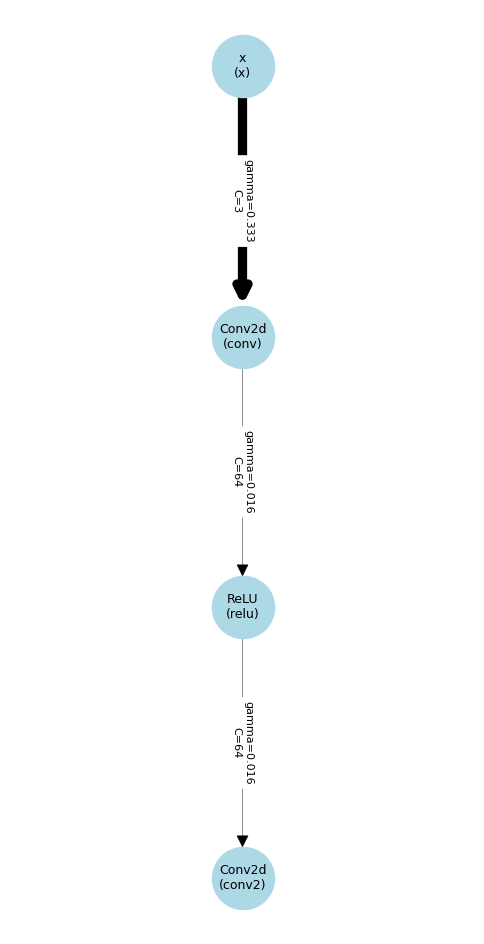

In [79]:
visualize_graph(graph_model, figsize=(6, 12))